In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import networkx as nx

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

# 2. Converging

In [4]:
x_0, x_N = 0, 100
N_x = 10
T_sim = 2
N_t = 1000
I = 1.0

dx = (x_N - x_0)/(N_x)
dt = T_sim/N_t

[]

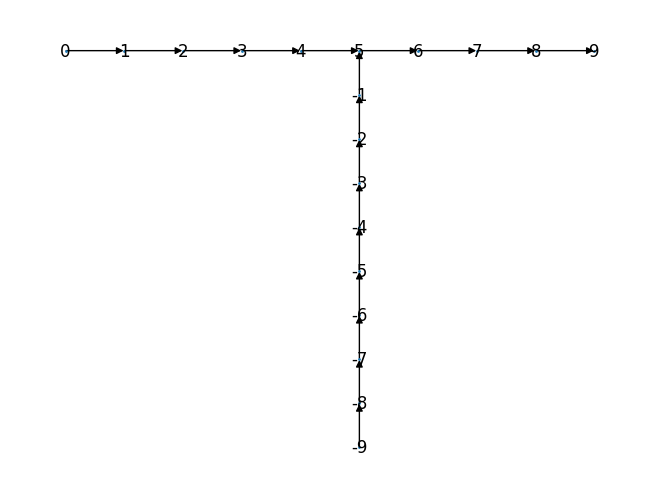

In [8]:
G = nx.DiGraph()

G.add_nodes_from([i for i in range(N_x)] + [-i for i in range(1, N_x)])
G.add_edges_from([(i,i+1) for i in range(N_x-1)] + [(-i-1, -i) for i in range(1,N_x-1)] + [(-1, int(N_x/2))])

pos = {i: (i, 0) for i in range(N_x)} | {-i: (int(N_x/2), -i) for i in range(1, N_x+1)}

nx.draw(G, pos, node_size=1, with_labels=True )
plt.plot()

In [20]:
for i,j in G.edges:
    rho = rho_max/2
    G.edges[i, j]['rho_old'] = rho
    G.edges[i, j]['Q_old'] = Q_e(rho)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


InEdgeDataView([(0, 1, {'rho': 60.0, 'rho_old': 60.0, 'Q_old': Array(1499.9999, dtype=float32, weak_type=True)})])

In [32]:
next(iter(G.in_edges(1, data=True)))

(0,
 1,
 {'rho': 60.0,
  'rho_old': 60.0,
  'Q_old': Array(1499.9999, dtype=float32, weak_type=True)})

In [18]:
i, j = 1, 2
rho_k = G.edges[i, j]['rho_old']
Q_k = G.edges[i, j]['Q_old']

edges_k_m1 = G.in_edges(i, data=True)
edges_k_p1 = G.out_edges(j, data=True)

data_k_m1 = next(iter(edges_k_m1))[2]
data_k_p1 = next(iter(edges_k_p1))[2]

rho_k_m1 = data_k_m1['rho_old']
Q_k_m1 = data_k_m1['Q_old']

rho_k_p1 = data_k_p1['rho_old']
Q_k_p1 = data_k_p1['Q_old']

S_k = jnp.where(rho_k>rho_C, Q_k, C)
S_k_p1 = jnp.where(rho_k_p1>rho_C, Q_k_p1, C)
D_k_m1 = jnp.where(rho_k_m1<=rho_C, Q_k_m1, C)
D_k = jnp.where(rho_k<=rho_C, Q_k, C)
Q_up = min(S_k, D_k_m1)
Q_down = min(S_k_p1, D_k)
rho_k = rho_k + dt/dx*(Q_up - Q_down)

G.edges[i, j]['rho_new'] = rho_k
G.edges[i, j]['Q_new'] = Q_e(rho_k)

60.0

# 1. Diverging

In [3]:
G = nx.DiGraph()

G.add_nodes_from([0,1,2,3,4,5])
G.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])

pos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}

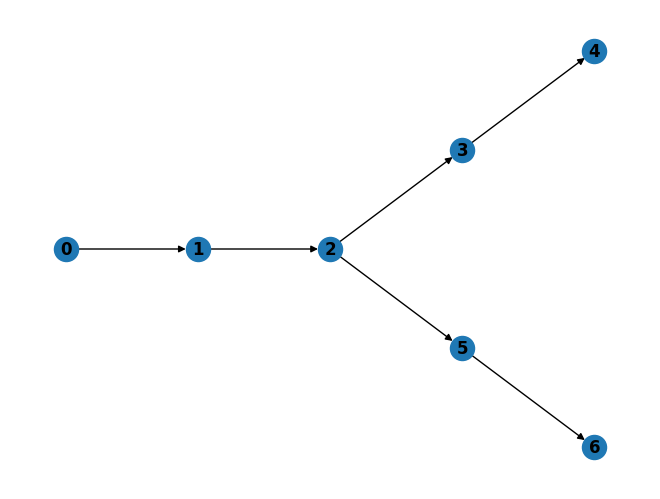

In [9]:
nx.draw(G, pos, with_labels=True, font_weight='bold')